# Introduction

In recent years, esports has seen a significant increase in popularity. What started as a niche hobby played in internet cafes has now become a global phenomenon that is hard to fathom. Today, multiple games are big enough to hold events in major sports venues like Madison Square Garden and Oracle Arena. Prize pools for these events regularly exceed millions of dollars and top players are treated like celebrities.

One of the most popular esports titles in the 2010s has been Counter Strike: Global Offensive (CS:GO), a team-based tactical first-person shooter game played on PC. The game was released in 2013, but earlier versions of the game date back to 1999. CS:GO has had hundreds of top-level tournaments and hundreds of players and teams vying to be the best over its ten-year tenure as an esports title. This project will go through the full data science pipeline as it relates to CS:GO's professional scene, attempt to answer a couple of questions through exploratory data analysis, and create a machine learning model to make future predictions about players and teams.

More information about CS:GO as a game can be found <a href='https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive'>here</a>.

In [1]:
import pandas as pd
import os
import bs4
import requests
import datetime  
import xlwt
import openpyxl
import re
import _pickle as pickle
import numpy as np
from plotnine import *

# Data Collection

The go-to source for stats in CS:GO is <a href='https://www.hltv.org/'>HLTV</a>. They've been collecting data on professional games since the early versions of Counter Strike since late 2015, have maintained a team ranking list based on recent performance. These rankings are widely accepted in the CS:GO community and are, for the most part, considered accurate. In addition, HLTV has created a rating system to simplify a player's performance in a match into a single number, known as the HLTV rating. This takes into account various factors in the game, such as the number of eliminations a player gets in the match, the amount of times the player gets eliminated, and how much damage the player is doing to the enemy team.

However, the HLTV rating doesn't consider the skill level of the opposing team. As a result, there are players with high ratings who have padded their stats against weaker teams. This is important to keep in mind as the project moves on to the exploratory data analysis section, where question such as who is the best player of the year would be answered, which considers all kinds of factors initiated from the data.


### 1) Historical Team Rank Data

To determine this, **scraping historical ranking data will be the first step**. Since one goal is to see which players perform well against the best teams, it makes sense to start by collecting this information. The rankings are published weekly on Monday, so I will start by writing a function that collects every Monday from the first record of HLTV's rankings.

In [2]:
def all_mondays(year): 
    return pd.date_range(start=str(year), end=str(year + 1), freq='W-MON').tolist()

def all_ranking_days_uptotoday():
    days = []
    firstRanking = pd.to_datetime(pd.Timestamp(year=2015, month=10, day=26))    
    for i in range(2015, datetime.datetime.today().year+1):
        days += all_mondays(i)   #now need to select days that are in the range
    days_final=[x for x in days if x>=firstRanking and x<=datetime.datetime.today()]
    return days_final

To gather the data for each team ranking page on HLTV, it is important to understand the URL format on HTML. The format for each team ranking on HLTV is as follows: **hltv.org/ranking/teams/YEAR/MONTH/DAY**. With this information, I can use the previously defined utility method to create a list of days and insert the date in the specified format. Then, using web scraping techniques with BeautifulSoup, the historical ranking data would be obtained.

Next, I am going to make sure the results get cached, so that I don't have to run this time-consuming operation every time I want to test the code or make a change. To save more time, I am using <a href='https://docs.python.org/3/library/pickle.html'>pickle</a> to save the dataframe that is being collected.

In [3]:
def get_all_data():
    days=all_ranking_days_uptotoday()
    rows=[]
    for monday in days:
        next_cycle=monday+pd.Timedelta(days=6)
        site_link='https://www.hltv.org/ranking/teams/'+str(monday.year)+'/'+str(monday.month_name()).lower()+'/'+str(monday.day) 
        site=requests.get(site_link)
        content=bs4.BeautifulSoup(site.text,'lxml')
        res=[]
        total_len=len(content.findAll('div',{'class' : 'ranked-team standard-box'}))
        for i in range(total_len):
            content_text=content.findAll('div',{'class' : 'ranked-team standard-box'})[i]
            team_name=content_text.find('span',{'class' : 'name'}).text
            team_rank=int(content_text.find('span',{'class' : 'position'}).text[1:])
            all_team_player_name=content_text.findAll('div',{'class' : 'nick'})
            team_player_name=[x.text for x in all_team_player_name]
            team_points=int(re.search(r'\d+',content_text.find('span',{'class' : 'points'}).text).group())
            date_range = pd.date_range(start=monday, end=next_cycle)
            for d in date_range:
                res.append([d, team_name, team_rank, team_player_name,team_points])
        rows=rows+res
    df = pd.DataFrame(data=rows, columns=['date','name','rank','players','points'])
    return df

if not os.path.exists('date_team_rank.pickle'):
    rankings_df = get_all_data()
    rankings_df.to_pickle('date_team_rank.pickle')
else:
    rankings_df = pd.read_pickle('date_team_rank.pickle')
rankings_df       

,date,name,rank,players
0,2015-10-26,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
1,2015-10-27,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
2,2015-10-28,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
3,2015-10-29,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
4,2015-10-30,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
...,...,...,...,...
75588,2023-01-18,HAVU,30,"[zehN, Aerial, xseveN, doto, spargo]"
75589,2023-01-19,HAVU,30,"[zehN, Aerial, xseveN, doto, spargo]"
75590,2023-01-20,HAVU,30,"[zehN, Aerial, xseveN, doto, spargo]"
75591,2023-01-21,HAVU,30,"[zehN, Aerial, xseveN, doto, spargo]"


Then, it is important to change the date column into a proper date format

In [4]:
rankings_df['date']=pd.to_datetime(rankings_df['date'])

#放之后
original_data['players'].apply(len).value_counts() #find out special scenarios of 6-man-team, 4-man-team, or a regular 5-man-team

#放之后
rankings_df

#放之后
original_data_with_all_players['player6'].value_counts() # knowing there are 7 cases where player6 exist

#放之后
original_data_with_all_players[original_data_with_all_players['player6']=='Stewie2K'] #allocate to the above 6-man-team cases 

#放之后
# A general way of creating 6-man-team data without knowing the name of player6
data_with_only_sixmangroup=original_data[original_data['players'].apply(len)==6]   #seperate 6-man-team into different dataset
data_with_only_sixmangroup.reset_index(inplace=True)
data_with_only_sixmangroup.drop(columns='index',inplace=True)

data_with_only_sixmangroup=pd.concat([data_with_only_sixmangroup,pd.DataFrame(data_with_only_sixmangroup['players'].tolist(),columns=['player1', 'player2','player3','player4','player5','player6'])],axis=1)
data_with_only_sixmangroup.drop(columns='players',inplace=True)
data_with_only_sixmangroup.set_index('date',inplace=True)
data_with_only_sixmangroup 

#放之后
a=original_data_with_all_players['2015-11-01':'2015-11-01'] #want to find a particular team's rank at a specific date
a[a['name']=='TSM'] # 可以做成一个function 或者交互性？1/3/2023

#放之后
original_data_with_all_players[original_data_with_all_players['player4']=='device']  #or does not work here

#放之后
a=original_data_with_all_players['player4']=='device'  #returning T or F
# has to assign it to a value. Can't use original_data_with_all_players['player5']=='device'|original_data_with_all_players['player4']=='device'
b=original_data_with_all_players['player5']=='device' 
a|b  # can not use 'and' or 'or' here
original_data_with_all_players[a|b] 

#放之后
original_data_with_all_players[original_data_with_all_players['player4']=='device']['player4'].to_frame()  # visualize Series into DataFrame

### 2）Player Stats Data

# getting all individual players data from the beginning to now#

https://www.hltv.org/stats/players?rankingFilter=Top30
#could get deeper into different years, which sides they are playing(ct-side or t-side). Now is both-sides.


In [5]:
#write it a function
#for all-matches data(including lan and online) and for top-30 teams only
# eg https://www.hltv.org/stats/players/7998/s1mple?rankingFilter=Top30
#only from overview's page data

def get_top_players_data_dict_from_start():
    player_sitelink_dict={}
    top_30_link=requests.get('https://www.hltv.org/stats/players?rankingFilter=Top30')
    content_top_30_soup=bs4.BeautifulSoup(top_30_link.text,'lxml')
    stats_table=content_top_30_soup.findAll('table',class_='stats-table player-ratings-table')[0]
    stats_table_tbody=stats_table.find('tbody')
    stats_table_tbody_top30_info_list=stats_table_tbody.findAll('td',class_='playerCol')
    for i in range(len(stats_table_tbody_top30_info_list)):
        player_sitelink_dict[stats_table_tbody_top30_info_list[i].text]='https://www.hltv.org'+stats_table_tbody_top30_info_list[i].find('a')['href']
    return player_sitelink_dict

def get_top_players_data_from_start():
    player_sitelink_dict=get_top_players_data_dict_from_start()
    rows=[]
    for players_name,players_link in player_sitelink_dict.items():
        res=[]
        players_page=requests.get(players_link)
        players_soup=bs4.BeautifulSoup(players_page.text,'lxml')
        players_team=players_soup.findAll('div',class_='SummaryTeamname text-ellipsis')[0].text
        players_age=int(players_soup.findAll('div',class_='summaryPlayerAge')[0].text.split()[0])
        players_match_played=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[6].text).group())
        players_round_played=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[7].text).group())
        player_total_killed=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[0].text).group())
        player_total_death=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[2].text).group())
        player_kd_diff=player_total_killed-player_total_death
        players_rating_2_0=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[0].text)
        players_DPR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[1].text)
        players_KAST=players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[2].text
        players_impact=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[3].text)
        players_ADR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[4].text)
        players_KPR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[5].text)
        
        players_AssistsPR=float(re.search(r'\d\.\d\d',players_soup.findAll('div',class_='stats-row')[9].text).group())
        players_rating_again_top5=float(players_soup.findAll('div',class_='rating-value')[0].text)
        players_HS_rate=re.search(r'\d\d\.\d+',players_soup.findAll('div',class_='stats-row')[1].text).group()
        res.append([players_name,players_team,players_age,players_match_played,players_round_played,player_total_killed,player_total_death,player_kd_diff,players_rating_2_0,players_DPR,players_KAST,players_impact,players_ADR,players_KPR,players_AssistsPR,players_rating_again_top5,players_HS_rate])
        rows=rows+res
    df=pd.DataFrame(rows,columns=['name','team','age','Match Played','Round Played','Total Kill','Total Death','KD Diff','Rating 2.0','DPR','KAST','Impact','ADR','KPR','AssistPR','Rating vs top5','HS Rate'])
    return df


In [6]:

if not os.path.exists('top_players_stats_from_start.pickle'):
    top_players_stats_from_start=get_top_players_data_from_start()
    top_players_stats_from_start.to_pickle('top_players_stats_from_start.pickle')
else:
    top_players_stats_from_start = pd.read_pickle('top_players_stats_from_start.pickle')
top_players_stats_from_start

,name,team,age,Match Played,Round Played,Total Kill,Total Death,KD Diff,Rating 2.0,DPR,KAST,Impact,ADR,KPR,AssistPR,Rating vs top5,HS Rate
0,s1mple,Natus Vincere,25,1203,31966,27137,19836,7301,1.25,0.62,74.0%,1.35,85.6,0.85,0.10,1.26,41.4
1,ZywOo,Vitality,22,756,20164,16422,12148,4274,1.29,0.60,75.0%,1.36,84.5,0.81,0.12,1.25,39.2
2,device,Astralis,27,1304,34233,26506,21320,5186,1.16,0.62,71.1%,1.28,80.3,0.77,0.12,1.13,33.8
3,NiKo,G2,25,1408,37536,29482,24972,4510,1.14,0.67,71.0%,1.30,85.7,0.79,0.13,1.19,50.3
4,coldzera,00NATION,28,1145,30181,22819,18796,4023,1.13,0.62,72.9%,1.08,78.4,0.76,0.11,1.11,49.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,MSL,No team,28,939,24901,15378,18198,-2820,0.87,0.73,66.2%,1.02,69.6,0.62,0.14,0.91,38.2
119,Zeus,No team,35,720,19150,11303,13104,-1801,0.87,0.68,68.2%,0.87,69.0,0.59,0.16,0.88,43.9
120,Golden,Savage,28,590,15830,9301,11144,-1843,0.90,0.70,66.3%,0.87,66.5,0.59,0.13,0.89,52.7
121,gob b,BIG,35,580,15364,8509,10574,-2065,0.83,0.69,66.9%,0.81,65.1,0.55,0.13,0.82,48.8


### 3) Historical Player Match Data

Since the project is particularly interested in individual player performance, so I will be retrieving data from the <a href='https://www.hltv.org/stats/players'>players section on HLTV</a>.

HLTV has data from almost every professional CS:GO match ever played, including obscure semi-professional games. In order to eliminate outliers clouding up the data, I am going to set the match filter to LAN (since results achieved on a LAN hold much more weight in the eyes of the community than online games), and set the ranking filter to top 30 teams, as realistically we are looking for a player who has played at the highest level of the game. 

With these filters factored in, the URL we're going to be using to get the list of players is https://www.hltv.org/stats/players?matchType=Lan&rankingFilter=Top30. This link, however, doesn't give the data I need. For that, I need to scrape individual player stats page URLs from this page, and grab the data from those individual pages (an example page for this would be https://www.hltv.org/stats/players/7998/s1mple?matchType=Lan&rankingFilter=Top30). 

And to get to the player match data page, it is needed to transform above link into a similar format: https://www.hltv.org/stats/players/matches/7998/s1mple?matchType=Lan&rankingFilter=Top30.


Start by defining a method that will scrape the players page and grab the links.

Noted the difference:

https://www.hltv.org/stats/players/7998/s1mple?matchType=Lan&rankingFilter=Top30

https://www.hltv.org/stats/players/matches/7998/s1mple?matchType=Lan&rankingFilter=Top30

In [7]:
def get_top_30_players_match_dict():
    player_match_sitelink_dict={}
    top_30_link=requests.get('https://www.hltv.org/stats/players?rankingFilter=Top30')
    content_top_30_soup=bs4.BeautifulSoup(top_30_link.text,'lxml')
    stats_table=content_top_30_soup.findAll('table',class_='stats-table player-ratings-table')[0]
    stats_table_tbody=stats_table.find('tbody')
    stats_table_tbody_top30_info_list=stats_table_tbody.findAll('td',class_='playerCol')
    for i in range(len(stats_table_tbody_top30_info_list)):
        player_match_sitelink_dict[stats_table_tbody_top30_info_list[i].text]='https://www.hltv.org'+stats_table_tbody_top30_info_list[i].find('a')['href'][:15]+'matches/'+stats_table_tbody_top30_info_list[i].find('a')['href'][15:]
    return player_match_sitelink_dict
    

After finishing the player links, it's time to dive into each individual player's match statistics page.

And similar to the rankings data, I am going to cache this dataframe and save it to a pickle.

In [8]:
def get_top_30_players_match_data():
    player_match_sitelink_dict=get_top_30_players_match_dict()
    rows=[]
    for players_name,players_match_link in player_match_sitelink_dict.items():
        players_match_page=requests.get(players_match_link)
        players_match_soup=bs4.BeautifulSoup(players_match_page.text,'lxml')
        players_match_soup_table=players_match_soup.find('table')
        players_match_soup_table_tbody=players_match_soup_table.find('tbody')
        players_match_soup_table_tbody_rows=players_match_soup_table_tbody.findAll('tr')
        for row in players_match_soup_table_tbody_rows:   #fast than using for i in range(..)
            match_data_origin=row.findAll('td')
            match_date=match_data_origin[0].find('div').text
            match_player_team=match_data_origin[1].find('span').text
            match_team_1_score=int(re.search(r'\d+',re.search(r'\W\d+',match_data_origin[1].text).group()).group())
            match_opponent=match_data_origin[2].find('span').text
            match_team_2_score=int(re.search(r'\d+',re.search(r'\W\d+',match_data_origin[2].text).group()).group())
            match_map=match_data_origin[3].text
            match_kill=int(re.findall(r'\d+',match_data_origin[4].text)[0])
            match_death=int(re.findall(r'\d+',match_data_origin[4].text)[1])
            match_kddiff=match_kill-match_death
            match_rating=float(re.search(r'\d\D\d+',match_data_origin[-1].text).group())
            rows.append([match_date,players_name,match_player_team,match_team_1_score,match_opponent,match_team_2_score,match_map,match_kill,match_death,match_kddiff,match_rating])
    df = pd.DataFrame(data=rows, columns=['Date','Player','Player team','T1 Score','Opponent','T2 Score','Map','Kill','Death','KD Diff','Rating 2.0'])     
    return df
 
if not os.path.exists('match_sample.pickle'):
    player_match_data = get_top_30_players_match_data()
    player_match_data.to_pickle('match_sample.pickle')
else:
    player_match_data = pd.read_pickle('match_sample.pickle')

player_match_data #takes aboout 6mins!!!!!

,Date,Player,Player team,T1 Score,Opponent,T2 Score,Map,Kill,Death,KD Diff,Rating 2.0
0,10/2/23,s1mple,Natus Vincere,16,Outsiders,12,inf,15,16,-1,1.05
1,10/2/23,s1mple,Natus Vincere,16,Outsiders,13,ovp,23,14,9,1.32
2,7/2/23,s1mple,Natus Vincere,7,G2,16,nuke,17,16,1,1.06
3,7/2/23,s1mple,Natus Vincere,8,G2,16,inf,11,17,-6,0.86
4,5/2/23,s1mple,Natus Vincere,19,Liquid,17,anb,25,21,4,1.14
...,...,...,...,...,...,...,...,...,...,...,...
109206,19/10/15,daps,Conquest,16,Winterfox,14,cbl,19,23,-4,0.85
109207,19/10/15,daps,Conquest,16,Method,3,ovp,11,8,3,1.08
109208,18/10/15,daps,Conquest,16,Method,7,d2,18,16,2,1.26
109209,18/10/15,daps,Conquest,16,Winterfox,13,inf,21,19,2,1.09


Noted it is important to change the format of the Date column.

In [9]:
player_match_data['Date']=pd.to_datetime(player_match_data['Date'],format='%d/%m/%y')

And with that, all data collection of this project is complete. Next, some modifications to the data are needed for the use.

# Data Manipulation

Now, it is time to adjust the format of the above data to streamline process and create statistics that aren't readily available on the HLTV stats page.

### 1) Change on Historical Team Rank Data

The original team rank data consists of two parts that are needed for change:

1)**index**: the index part really does not provide any information to the goal of the project. Instead, dropping it and replacing it with date-index is much helpful,

2)**players**: the original player column is a list of players' name in a team. By placing the column with multiple columns with different names would be convenient for future uses. However, there are situations of a team with six players for a period of time. Instead of dropping these data, the default of new dataframe is made of six players where **None** would be the value if there is no sixth player found in a team.

In [10]:
ranking_all_players=pd.concat([rankings_df,pd.DataFrame(rankings_df['players'].tolist(),columns=['player1', 'player2','player3','player4','player5','player6'])],axis=1)
ranking_all_players.drop(columns='players',inplace=True)
ranking_all_players.set_index('date',inplace=True)
ranking_all_players   #will consider all scenarios in this DataFrame

,name,rank,player1,player2,player3,player4,player5,player6
date,,,,,,,,
2015-10-26,TSM,1,karrigan,cajunb,Xyp9x,dupreeh,device,None
2015-10-27,TSM,1,karrigan,cajunb,Xyp9x,dupreeh,device,None
2015-10-28,TSM,1,karrigan,cajunb,Xyp9x,dupreeh,device,None
2015-10-29,TSM,1,karrigan,cajunb,Xyp9x,dupreeh,device,None
2015-10-30,TSM,1,karrigan,cajunb,Xyp9x,dupreeh,device,None
...,...,...,...,...,...,...,...,...
2023-01-18,HAVU,30,zehN,Aerial,xseveN,doto,spargo,None
2023-01-19,HAVU,30,zehN,Aerial,xseveN,doto,spargo,None
2023-01-20,HAVU,30,zehN,Aerial,xseveN,doto,spargo,None


### 2）Change on Historical Player Match Data

Now, it is time to adjust the format of the data to streamline process and create statistics that aren't readily available on the HLTV stats page.

To provide more context about each match, I need to know the ranking of the opposing team during the time of the match as to have a better understanding of overall skill level of the match. Fortunately, it can be achieved by linking two dataframes together: **team rank data** and **player match data**.

Therefore, here is the function of getting the rank of a particular team, and I will set the value of unranked teams to be -1.

In [11]:
def get_team_rank(team, date):
    try:
        subset = ranking_all_players.loc[date] # get rankings on that date,
        if len(subset) == 0:   #case when there is no result found on that date
            return -1
        rows = subset[subset['name'] == team]      #date qualified/ name qualified
        if len(rows) == 0:      #if there is no name found
            return -1
        row = rows.iloc[[0]]  #相比较于[0] 显示的是dataframe的形式
        return row['rank'].iloc[0]
    except KeyError:
        return -1

Next, I will make all the changes to the dataset along with adding the following fields:

- **Win**: A logical column defining if the match is a win or loss for the player in question by comparing the rounds player's team won to the rounds the opposing team won, defined as **(T1 Score > T2 Score)**
- **Opposing_Team_Rank**: using the get_team_rank function created before, and similar for the **Team_Rank**
- **Rank_Differential**: The difference in rank between the two teams (note that if either team is unranked, I am going to treat the differential as **None**)
- **KDR**: The kill/death ratio of the player during the specific match, defined as **(kills / deaths)** 
- **KPR**: The kills per round statistic of the player during the specific match, defined as **(kills / (team rounds + opposing team rounds))**

In essence, trying to find out which CS:GO players play best at against all levels is the ultimate goal. Noted that some players might just pad their stats against weaker opponents. To solve this problem, it is important to develop an "**Importance**" metric for each match, based on the rank differential between the two teams. And the "importance" level would be subbed into following categories (which might be better improved in future version?):

- Case 1: which is the base case that Importance=1 for all matches
- Case 2: if the sum of the two team's scores is no less than 28, then Importance=1.5. Because as the match lasts longer, it usually means both teams are really competitive.
- Case 3: if both team's rank are between 0 and 10, then Importance=1.75 since two higher ranks team are competing.
- Case 4: if both team's rank are between 0 and 5, then Importance=2.

After it, I am going to create a column called **performance**:
- **Performance**: the result of multiplying a given match's importance to the player's rating during that match, defined as **(importance * rating 2.0)**

And finally, all of the matches where rank_diff is None would be removed to have a better view of high-level competitive match results. But still, this final filtered results would be cached into another pickle called **player_match_data_effective**, I can still view the original match result in player_match_data. 

In [12]:
if not os.path.exists('player_match_data_effective.pickle'):
    player_match_data['Win']=player_match_data['T1 Score']>player_match_data['T2 Score']
    player_match_data['opposing_team_rank'] = -1  # just to create the column
    player_match_data['team_rank'] = -1
    player_match_data['KDR']=player_match_data['Kill']/player_match_data['Death']
    player_match_data['KPR']=player_match_data['Kill']/(player_match_data['T1 Score']+player_match_data['T2 Score'])
    for index, row in player_match_data.iterrows():
        player_match_data.at[index, 'opposing_team_rank'] = get_team_rank(row['Opponent'], row['Date'])
        player_match_data.at[index, 'team_rank'] = get_team_rank(row['Player team'], row['Date'])
    player_match_data['opposing_team_rank'] = pd.to_numeric(player_match_data['opposing_team_rank'])
    player_match_data['team_rank'] = pd.to_numeric(player_match_data['team_rank']) #better than using int
    player_match_data['rank_diff']=player_match_data.apply(lambda row: None if row['team_rank']==-1 or row['opposing_team_rank']==-1 else row['opposing_team_rank']-row['team_rank'],axis=1)
    player_match_data['Importance']=1 #Case 1
    player_match_data.loc[player_match_data['T1 Score']+player_match_data['T2 Score']>=28,'Importance']=1.5 #Case 2
    player_match_data.loc[player_match_data['team_rank'].between(0,10,'both') & player_match_data['opposing_team_rank'].between(0,10,'both'),'Importance']=1.75 #Case 3
    player_match_data.loc[player_match_data['team_rank'].between(0,5,'both') & player_match_data['opposing_team_rank'].between(0,5,'both'),'Importance']=2 #Case 4
    player_match_data['Performance'] = player_match_data['Importance'] * player_match_data['Rating 2.0']
    player_match_data_effective=player_match_data[player_match_data['rank_diff'].notnull()] #all effective data are where rank_diff is not null
    player_match_data_effective.reset_index(inplace=True)
    player_match_data_effective.drop(columns=['index'],inplace=True)
    player_match_data_effective.to_pickle('player_match_data_effective.pickle')
else:
    player_match_data_effective=pd.read_pickle('player_match_data_effective.pickle')
player_match_data_effective

,Date,Player,Player team,T1 Score,Opponent,T2 Score,Map,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance
0,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,8,ovp,24,9,15,1.77,True,16,9,2.666667,1.000000,7.0,1.00,1.770
1,2023-01-21,s1mple,Natus Vincere,17,Ninjas in Pyjamas,19,mrg,29,19,10,1.21,False,16,9,1.526316,0.805556,7.0,1.50,1.815
2,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,9,inf,12,17,-5,0.79,True,16,9,0.705882,0.480000,7.0,1.00,0.790
3,2022-12-16,s1mple,Natus Vincere,9,Liquid,16,mrg,21,18,3,1.06,False,8,4,1.166667,0.840000,4.0,1.75,1.855
4,2022-12-16,s1mple,Natus Vincere,16,Liquid,14,anc,18,16,2,1.08,True,8,4,1.125000,0.600000,4.0,1.75,1.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84967,2015-11-12,daps,Conquest,16,CLG,13,ovp,23,19,4,1.12,True,13,17,1.210526,0.793103,-4.0,1.50,1.680
84968,2015-11-12,daps,Conquest,16,CLG,3,mrg,20,9,11,1.64,True,13,17,2.222222,1.052632,-4.0,1.00,1.640
84969,2015-11-12,daps,Conquest,12,CLG,16,d2,14,21,-7,0.77,False,13,17,0.666667,0.500000,-4.0,1.50,1.155
84970,2015-11-12,daps,Conquest,8,Liquid,16,cch,13,19,-6,0.70,False,14,17,0.684211,0.541667,-3.0,1.00,0.700


In [13]:
player_match_data_effective['Date']=pd.to_datetime(player_match_data_effective['Date'],format='%d/%m/%y')

And there are situations where player have **zero death** during a match, which is not ideal when calculating KDR. Here is one example.

In [14]:
player_match_data_effective.loc[player_match_data_effective['Death']==0]

,Date,Player,Player team,T1 Score,Opponent,T2 Score,Map,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance
1166,2022-05-09,ZywOo,Vitality,16,Complexity,1,inf,11,0,11,1.58,True,24,11,inf,0.647059,13.0,1.0,1.58
4745,2017-05-31,coldzera,SK,4,fnatic,0,trn,5,0,5,2.08,True,11,3,inf,1.250000,8.0,1.0,2.08


Therefore, it is better to change the death from 0 to 1, otherwise it will return Nah when calculating KDR.

In [15]:
player_match_data_effective.loc[player_match_data_effective['Death']==0,'Death']=1

And with that, all data required for further analysis and exploration are successfully prepared.

# Exploratory Data Analysis

The first thing of this section is to create a dataframe of the summarized results of the data.

The total rounds of each player played is also added to **player_match_data_effective**

In [16]:
player_match_data_effective['Game Round']=1
player_match_data_effective_group=pd.concat([player_match_data_effective.groupby(['Player']).agg('mean'),
                                             player_match_data_effective.groupby(['Player']).agg({'Game Round':['sum']})],axis=1)
player_match_data_effective_group.drop(columns=['Game Round'],inplace=True)
player_match_data_effective_group.sort_values('Performance',ascending=False)

,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,"(Game Round, sum)"
Player,,,,,,,,,,,,,,,
s1mple,13.987713,12.581285,22.562382,16.420605,6.141777,1.303847,0.586011,11.071834,5.165406,1.485954,0.852012,5.906427,1.509452,1.957944,1058
device,14.471014,12.232790,20.342391,16.292572,4.049819,1.227790,0.648551,10.090580,3.896739,1.392472,0.778312,6.193841,1.578804,1.917165,1104
ZywOo,13.900730,13.258394,21.675912,16.213139,5.464234,1.297182,0.567883,11.581022,7.043796,NaN,0.809410,4.537226,1.470438,1.892982,685
NiKo,13.884584,13.050040,20.945924,17.726392,3.219532,1.225537,0.547215,10.275222,6.971751,1.283663,0.785793,3.303471,1.498588,1.827090,1239
dupreeh,14.361826,12.443154,18.716183,17.098755,1.617427,1.127286,0.628216,10.063071,3.893776,1.198640,0.711078,6.169295,1.583402,1.770539,1205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Furlan,12.603399,13.900850,17.237960,18.886686,-1.648725,1.004079,0.419263,18.393768,21.980170,0.950378,0.645542,-3.586402,1.179887,1.190807,353
denis,13.027311,13.733193,16.571429,19.420168,-2.848739,0.955987,0.451681,14.768908,18.481092,0.907215,0.622382,-3.712185,1.241597,1.189496,476
v1c7oR,13.192623,13.266393,16.647541,18.885246,-2.237705,0.999549,0.475410,19.684426,22.930328,0.934983,0.634776,-3.245902,1.184426,1.186250,244


With that out of the way, now it is free to start graphing some of the findings to get a visual representation. The first thing I am going to graph is the average performance of each player vs the average rating of each player. This should give a better idea of how the two are correlated.

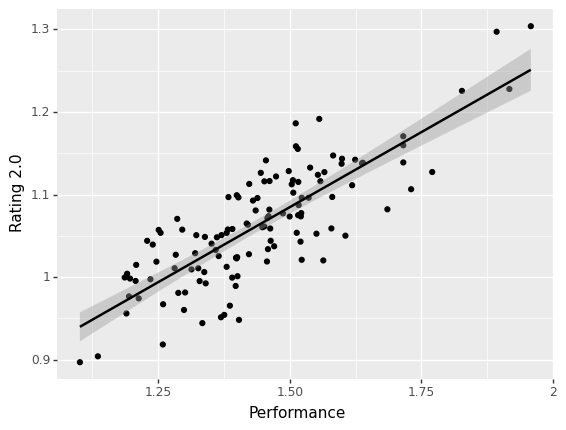

<ggplot: (159659967338)>

In [17]:
ggplot(player_match_data_effective_group,aes(x='Performance',y='Rating 2.0'))+geom_point()+stat_smooth(method='lm')

It seems to be a linear relationship, which makes sense. Next step is to graph the performance of the top 20 performing players over time (since HLTV generates top 20 players every year). 

To achieve this, a list of overall top 20 player would be created based on their performance.

In [18]:
player_match_data_effective.groupby(['Player']).mean().sort_values('Performance', ascending=False).head(20)

,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,Game Round
Player,,,,,,,,,,,,,,,
s1mple,13.987713,12.581285,22.562382,16.420605,6.141777,1.303847,0.586011,11.071834,5.165406,1.485954,0.852012,5.906427,1.509452,1.957944,1.0
device,14.471014,12.232790,20.342391,16.292572,4.049819,1.227790,0.648551,10.090580,3.896739,1.392472,0.778312,6.193841,1.578804,1.917165,1.0
ZywOo,13.900730,13.258394,21.675912,16.213139,5.464234,1.297182,0.567883,11.581022,7.043796,NaN,0.809410,4.537226,1.470438,1.892982,1.0
NiKo,13.884584,13.050040,20.945924,17.726392,3.219532,1.225537,0.547215,10.275222,6.971751,1.283663,0.785793,3.303471,1.498588,1.827090,1.0
dupreeh,14.361826,12.443154,18.716183,17.098755,1.617427,1.127286,0.628216,10.063071,3.893776,1.198640,0.711078,6.169295,1.583402,1.770539,1.0
GuardiaN,13.714497,12.430473,18.442308,16.420118,2.022189,1.106435,0.554734,10.110947,4.544379,1.240807,0.706527,5.566568,1.572115,1.730514,1.0
Magisk,14.210164,12.765719,18.606374,16.936262,1.670112,1.138872,0.603790,11.065461,6.684755,1.206894,0.700997,4.380706,1.514212,1.715640,1.0
electroNic,13.819979,12.673257,19.200832,17.296566,1.904266,1.159615,0.577523,11.821020,6.284079,1.205116,0.726281,5.536941,1.486212,1.715614,1.0
coldzera,13.531780,12.934322,19.954449,16.389831,3.565678,1.170561,0.548729,11.236229,6.688559,NaN,0.768499,4.547669,1.469544,1.715538,1.0


In [19]:
top_20_player_list=list(player_match_data_effective.groupby(['Player']).mean().sort_values('Performance', ascending=False).head(20).index)
top_20_player_list

['s1mple',
 'device',
 'ZywOo',
 'NiKo',
 'dupreeh',
 'GuardiaN',
 'Magisk',
 'electroNic',
 'coldzera',
 'Xyp9x',
 'Twistzz',
 'fer',
 'EliGE',
 'rain',
 'gla1ve',
 'huNter-',
 'NAF',
 'ropz',
 'FalleN',
 'flamie']

In [20]:
player_match_data_effective['top_20_player'] = player_match_data_effective.apply(lambda row: row['Player'] in top_20_player_list, axis=1)

In [21]:
player_match_data_effective

,Date,Player,Player team,T1 Score,Opponent,T2 Score,Map,Kill,Death,KD Diff,...,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,Game Round,top_20_player
0,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,8,ovp,24,9,15,...,True,16,9,2.666667,1.000000,7.0,1.00,1.770,1,True
1,2023-01-21,s1mple,Natus Vincere,17,Ninjas in Pyjamas,19,mrg,29,19,10,...,False,16,9,1.526316,0.805556,7.0,1.50,1.815,1,True
2,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,9,inf,12,17,-5,...,True,16,9,0.705882,0.480000,7.0,1.00,0.790,1,True
3,2022-12-16,s1mple,Natus Vincere,9,Liquid,16,mrg,21,18,3,...,False,8,4,1.166667,0.840000,4.0,1.75,1.855,1,True
4,2022-12-16,s1mple,Natus Vincere,16,Liquid,14,anc,18,16,2,...,True,8,4,1.125000,0.600000,4.0,1.75,1.890,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84967,2015-11-12,daps,Conquest,16,CLG,13,ovp,23,19,4,...,True,13,17,1.210526,0.793103,-4.0,1.50,1.680,1,False
84968,2015-11-12,daps,Conquest,16,CLG,3,mrg,20,9,11,...,True,13,17,2.222222,1.052632,-4.0,1.00,1.640,1,False
84969,2015-11-12,daps,Conquest,12,CLG,16,d2,14,21,-7,...,False,13,17,0.666667,0.500000,-4.0,1.50,1.155,1,False
84970,2015-11-12,daps,Conquest,8,Liquid,16,cch,13,19,-6,...,False,14,17,0.684211,0.541667,-3.0,1.00,0.700,1,False


Successfully created top_20 (boolean) list.

Next, I am going to resample the data so that I can get the average stats information for players on a 3-months basis. This will give a rough idea of the ups and downs of certain players over the duration that HLTV has been keeping track of rankings. Meanwhile, I want to show how many matches the player played during these 3-months

In [22]:
player_match_data_effective_group_sum=player_match_data_effective.groupby(['Player']).resample('3M', on='Date')[player_match_data_effective.columns[19]].sum() 
#19th column is Game Round
player_match_data_effective_group_sum=player_match_data_effective_group_sum.reset_index()
player_match_data_effective_group_sum

,Player,Date,Game Round
0,ALEX,2015-11-30,1
1,ALEX,2016-02-29,0
2,ALEX,2016-05-31,0
3,ALEX,2016-08-31,0
4,ALEX,2016-11-30,3
...,...,...,...
2942,woxic,2021-11-30,0
2943,woxic,2022-02-28,24
2944,woxic,2022-05-31,16
2945,woxic,2022-08-31,16


In [23]:
player_match_data_effective_group_sum.rename({'Player':'player1','Date':'date1','Game Round':'Game_round1'},axis=1,inplace=True) 
#change the column name for future concat usage
player_match_data_effective_group_sum

,player1,date1,Game_round1
0,ALEX,2015-11-30,1
1,ALEX,2016-02-29,0
2,ALEX,2016-05-31,0
3,ALEX,2016-08-31,0
4,ALEX,2016-11-30,3
...,...,...,...
2942,woxic,2021-11-30,0
2943,woxic,2022-02-28,24
2944,woxic,2022-05-31,16
2945,woxic,2022-08-31,16


In [24]:
#this is the part where I do aggregate mean for all columns
player_match_data_effective_group_mean=player_match_data_effective.groupby(['Player']).resample('3M', on='Date').mean().reset_index()
player_match_data_effective_group_mean

,Player,Date,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,Game Round,top_20_player
0,ALEX,2015-11-30,12.000000,21.0000,23.000000,25.000000,-2.000000,1.030000,0.000000,14.000000,1.000000,0.920000,0.696970,13.0000,1.500000,1.545000,1.0,0.0
1,ALEX,2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALEX,2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALEX,2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALEX,2016-11-30,12.000000,11.0000,17.000000,18.666667,-1.666667,1.116667,0.666667,17.000000,26.000000,0.914877,0.744444,-9.0000,1.166667,1.280000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,woxic,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943,woxic,2022-02-28,13.541667,12.2500,18.333333,15.291667,3.041667,1.130417,0.541667,24.833333,25.208333,1.290875,0.717321,-0.3750,1.187500,1.323542,1.0,0.0
2944,woxic,2022-05-31,14.312500,15.3125,20.437500,16.812500,3.625000,1.135625,0.375000,24.437500,27.500000,1.225574,0.681609,-3.0625,1.281250,1.465313,1.0,0.0
2945,woxic,2022-08-31,14.312500,15.1875,22.000000,17.750000,4.250000,1.130625,0.625000,14.500000,23.687500,1.303747,0.745697,-9.1875,1.312500,1.510625,1.0,0.0


In [25]:
player_match_data_effective_group_final=pd.concat([player_match_data_effective_group_mean,player_match_data_effective_group_sum],axis=1)
player_match_data_effective_group_final.drop(columns=['player1','date1','Game Round'],inplace=True)
player_match_data_effective_group_final.rename({'Game_round1':'Game_Played'},axis=1,inplace=True)
player_match_data_effective_group_final

,Player,Date,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,top_20_player,Game_Played
0,ALEX,2015-11-30,12.000000,21.0000,23.000000,25.000000,-2.000000,1.030000,0.000000,14.000000,1.000000,0.920000,0.696970,13.0000,1.500000,1.545000,0.0,1
1,ALEX,2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,ALEX,2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ALEX,2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,ALEX,2016-11-30,12.000000,11.0000,17.000000,18.666667,-1.666667,1.116667,0.666667,17.000000,26.000000,0.914877,0.744444,-9.0000,1.166667,1.280000,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,woxic,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2943,woxic,2022-02-28,13.541667,12.2500,18.333333,15.291667,3.041667,1.130417,0.541667,24.833333,25.208333,1.290875,0.717321,-0.3750,1.187500,1.323542,0.0,24
2944,woxic,2022-05-31,14.312500,15.3125,20.437500,16.812500,3.625000,1.135625,0.375000,24.437500,27.500000,1.225574,0.681609,-3.0625,1.281250,1.465313,0.0,16
2945,woxic,2022-08-31,14.312500,15.1875,22.000000,17.750000,4.250000,1.130625,0.625000,14.500000,23.687500,1.303747,0.745697,-9.1875,1.312500,1.510625,0.0,16


With that done, it is now for graphing. And it also features with the monthly avearge performance of all top_20 players, thus it can be visualized on the graph.

In [26]:
sample=player_match_data_effective_group_final[player_match_data_effective_group_final['top_20_player']==1.0]
sample.sort_values('Date',inplace=True)
sample.reset_index(inplace=True) #without reseting index, plotnine will not go on
sample.drop(columns='index',inplace=True)
sample.set_index('Date',inplace=True)
sample

C:\Users\bobie\AppData\Local\Temp\ipykernel_7704\148706644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bobie\AppData\Local\Temp\ipykernel_7704\148706644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,top_20_player,Game_Played
Date,,,,,,,,,,,,,,,,,
2015-10-31,EliGE,13.000000,17.500000,21.500000,25.000000,-3.500000,0.880000,0.000000,4.000000,11.000000,0.849359,0.685730,-7.000000,1.250000,1.182500,1.0,2
2015-10-31,GuardiaN,14.142857,12.571429,22.285714,17.000000,5.285714,1.187143,0.714286,10.571429,6.000000,1.361163,0.824472,4.571429,1.678571,1.988571,1.0,7
2015-10-31,NiKo,12.200000,14.200000,21.400000,18.200000,3.200000,1.120000,0.400000,10.000000,13.000000,1.189333,0.783333,-3.000000,1.200000,1.397000,1.0,5
2015-10-31,Xyp9x,12.500000,11.000000,17.500000,16.750000,0.750000,1.025000,0.500000,8.250000,1.000000,1.059237,0.749490,7.250000,1.687500,1.713750,1.0,4
2015-10-31,rain,14.857143,12.571429,17.714286,19.857143,-2.142857,0.941429,0.714286,8.428571,9.000000,0.934192,0.661050,-0.571429,1.464286,1.348929,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,Twistzz,14.846154,10.846154,21.230769,15.923077,5.307692,1.324615,0.615385,12.769231,3.384615,1.464421,0.838838,9.384615,1.288462,1.707692,1.0,13
2023-02-28,NAF,13.277778,12.777778,18.055556,15.111111,2.944444,1.136111,0.500000,9.722222,6.888889,1.390322,0.697621,2.833333,1.486111,1.674583,1.0,18
2023-02-28,gla1ve,11.875000,14.375000,16.750000,18.000000,-1.250000,0.965000,0.250000,14.375000,17.250000,0.937762,0.633403,-2.875000,1.250000,1.202500,1.0,8


In [27]:
sample['p_mean']=sample.groupby(pd.Grouper(freq='1M'))['Performance'].mean()
sample

C:\Users\bobie\AppData\Local\Temp\ipykernel_7704\671596576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,top_20_player,Game_Played,p_mean
Date,,,,,,,,,,,,,,,,,,
2015-10-31,EliGE,13.000000,17.500000,21.500000,25.000000,-3.500000,0.880000,0.000000,4.000000,11.000000,0.849359,0.685730,-7.000000,1.250000,1.182500,1.0,2,1.529541
2015-10-31,GuardiaN,14.142857,12.571429,22.285714,17.000000,5.285714,1.187143,0.714286,10.571429,6.000000,1.361163,0.824472,4.571429,1.678571,1.988571,1.0,7,1.529541
2015-10-31,NiKo,12.200000,14.200000,21.400000,18.200000,3.200000,1.120000,0.400000,10.000000,13.000000,1.189333,0.783333,-3.000000,1.200000,1.397000,1.0,5,1.529541
2015-10-31,Xyp9x,12.500000,11.000000,17.500000,16.750000,0.750000,1.025000,0.500000,8.250000,1.000000,1.059237,0.749490,7.250000,1.687500,1.713750,1.0,4,1.529541
2015-10-31,rain,14.857143,12.571429,17.714286,19.857143,-2.142857,0.941429,0.714286,8.428571,9.000000,0.934192,0.661050,-0.571429,1.464286,1.348929,1.0,7,1.529541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,Twistzz,14.846154,10.846154,21.230769,15.923077,5.307692,1.324615,0.615385,12.769231,3.384615,1.464421,0.838838,9.384615,1.288462,1.707692,1.0,13,1.618751
2023-02-28,NAF,13.277778,12.777778,18.055556,15.111111,2.944444,1.136111,0.500000,9.722222,6.888889,1.390322,0.697621,2.833333,1.486111,1.674583,1.0,18,1.618751
2023-02-28,gla1ve,11.875000,14.375000,16.750000,18.000000,-1.250000,0.965000,0.250000,14.375000,17.250000,0.937762,0.633403,-2.875000,1.250000,1.202500,1.0,8,1.618751


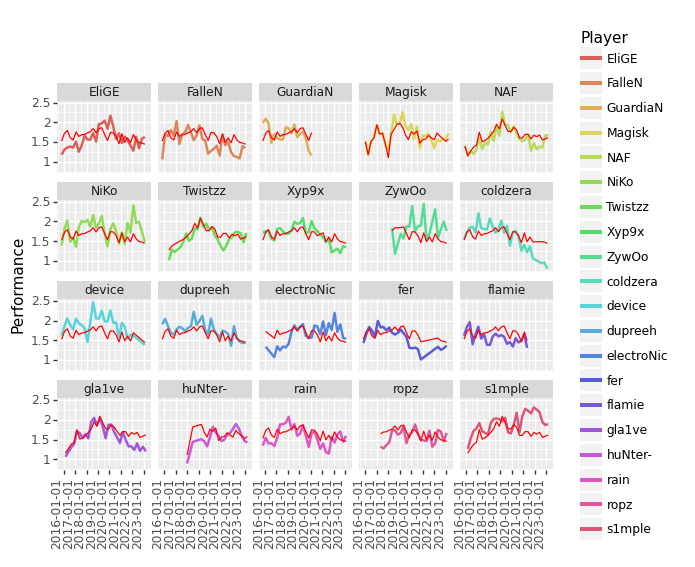

<ggplot: (159666074429)>

In [28]:
ggplot(sample,aes(x=sample.index,y='Performance'))+\
geom_line(aes(color='Player'), size=1)+\
facet_wrap('Player')+\
theme(axis_text_x=element_text(angle=90,hjust=1))+\
geom_line(aes(x=sample.index, y='p_mean'), color='red')

Above is the graph of all top 20 players along with the moving average performance of all 20 players. The key takeaways for this graph is that the highest performing player overall, s1mple, even had a period early in his career where his performance rating was actually quite subpar (lower than other players), but he turned it around and had multiple time periods where his performance outranked his peers.

Next, lets look at kill/death ratio (KDR) vs performance.


E:\anac\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


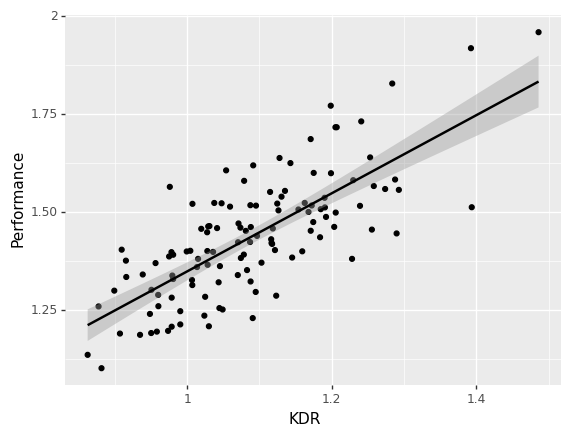

<ggplot: (159666415764)>

In [29]:
(ggplot(player_match_data_effective_group, aes(x='KDR', y='Performance'))
    + geom_point()
    + geom_smooth(method='lm'))

It appears that the two are definitely correlated in that the players with high average kill/death ratios will have high performance metrics. This is expected, as performance is influenced by kill rating.

Finally, lets look at the performance of teams over time using win percentage as the performance metric. I am going to do something similar to what I did for the top 20 players, but for teams instead. And the measure will take on the teams that have played the most games (with the most wins). This is to see how teams that have been at the top level for a long time have fluctuated over time.

In [30]:
player_match_data_effective.groupby(['Player team'])['Win'].sum().to_frame().reset_index().sort_values('Win',ascending=False).head(20)

,Player team,Win
10,Astralis,3637
32,FaZe,3225
38,G2,2795
63,Natus Vincere,2619
60,MOUZ,2566
64,Ninjas in Pyjamas,2398
56,Liquid,2397
105,fnatic,2354
11,BIG,1721
48,Heroic,1608


In [31]:
top_20_team_list=list(player_match_data_effective.groupby(['Player team'])['Win'].sum().to_frame().reset_index().sort_values('Win',ascending=False).head(20)['Player team'])
top_20_team_list #here got a list of top 20 team with the most wins over the time.

['Astralis',
 'FaZe',
 'G2',
 'Natus Vincere',
 'MOUZ',
 'Ninjas in Pyjamas',
 'Liquid',
 'fnatic',
 'BIG',
 'Heroic',
 'Virtus.pro',
 'Vitality',
 'North',
 'Cloud9',
 'SK',
 'OpTic',
 'NRG',
 'HellRaisers',
 'Envy',
 'OG']

In [32]:
player_match_data_effective['top_20_team']=player_match_data_effective.apply(lambda row: row['Player team'] in top_20_team_list,axis=1)
player_match_data_effective

,Date,Player,Player team,T1 Score,Opponent,T2 Score,Map,Kill,Death,KD Diff,...,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,Game Round,top_20_player,top_20_team
0,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,8,ovp,24,9,15,...,16,9,2.666667,1.000000,7.0,1.00,1.770,1,True,True
1,2023-01-21,s1mple,Natus Vincere,17,Ninjas in Pyjamas,19,mrg,29,19,10,...,16,9,1.526316,0.805556,7.0,1.50,1.815,1,True,True
2,2023-01-21,s1mple,Natus Vincere,16,Ninjas in Pyjamas,9,inf,12,17,-5,...,16,9,0.705882,0.480000,7.0,1.00,0.790,1,True,True
3,2022-12-16,s1mple,Natus Vincere,9,Liquid,16,mrg,21,18,3,...,8,4,1.166667,0.840000,4.0,1.75,1.855,1,True,True
4,2022-12-16,s1mple,Natus Vincere,16,Liquid,14,anc,18,16,2,...,8,4,1.125000,0.600000,4.0,1.75,1.890,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84967,2015-11-12,daps,Conquest,16,CLG,13,ovp,23,19,4,...,13,17,1.210526,0.793103,-4.0,1.50,1.680,1,False,False
84968,2015-11-12,daps,Conquest,16,CLG,3,mrg,20,9,11,...,13,17,2.222222,1.052632,-4.0,1.00,1.640,1,False,False
84969,2015-11-12,daps,Conquest,12,CLG,16,d2,14,21,-7,...,13,17,0.666667,0.500000,-4.0,1.50,1.155,1,False,False
84970,2015-11-12,daps,Conquest,8,Liquid,16,cch,13,19,-6,...,14,17,0.684211,0.541667,-3.0,1.00,0.700,1,False,False


In [33]:
team_win_overview=player_match_data_effective.groupby(['Player team']).resample('3M', on='Date').mean().reset_index()
team_win_overview_top_20=team_win_overview[team_win_overview['top_20_team']==1]
team_win_overview_top_20.set_index('Date',inplace=True)
team_win_overview_top_20

,Player team,T1 Score,T2 Score,Kill,Death,KD Diff,Rating 2.0,Win,opposing_team_rank,team_rank,KDR,KPR,rank_diff,Importance,Performance,Game Round,top_20_player,top_20_team
Date,,,,,,,,,,,,,,,,,,
2016-02-29,Astralis,14.520000,11.000000,18.392000,16.136000,2.256000,1.174320,0.640000,9.320000,4.000000,1.315100,0.733906,5.320000,1.560000,1.754900,1.0,0.600000,1.0
2016-05-31,Astralis,13.333333,11.589744,17.358974,16.128205,1.230769,1.107231,0.589744,8.051282,3.384615,1.242163,0.701992,4.666667,1.705128,1.861321,1.0,0.600000,1.0
2016-08-31,Astralis,14.458647,12.864662,19.872180,17.789474,2.082707,1.158496,0.571429,15.180451,7.751880,1.201083,0.732122,7.428571,1.357143,1.543440,1.0,0.646617,1.0
2016-11-30,Astralis,14.332326,11.879154,18.682779,16.858006,1.824773,1.139094,0.601208,10.256798,9.060423,1.234787,0.718985,1.196375,1.475076,1.664713,1.0,0.679758,1.0
2017-02-28,Astralis,14.444444,11.055556,18.427778,16.333333,2.094444,1.166500,0.722222,8.444444,2.305556,1.279719,0.727266,6.138889,1.618056,1.891014,1.0,0.800000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,fnatic,13.736842,14.578947,18.649123,19.473684,-0.824561,1.013684,0.578947,11.736842,17.000000,0.996300,0.655579,-5.263158,1.289474,1.319561,1.0,0.000000,1.0
2022-04-30,fnatic,12.690141,13.028169,17.014085,17.605634,-0.591549,1.045211,0.450704,11.816901,15.225352,1.053124,0.663383,-3.408451,1.154930,1.198873,1.0,0.000000,1.0
2022-07-31,fnatic,6.500000,16.000000,11.750000,19.250000,-7.500000,0.672500,0.000000,16.000000,18.000000,0.619674,0.522727,-2.000000,1.000000,0.672500,1.0,0.000000,1.0


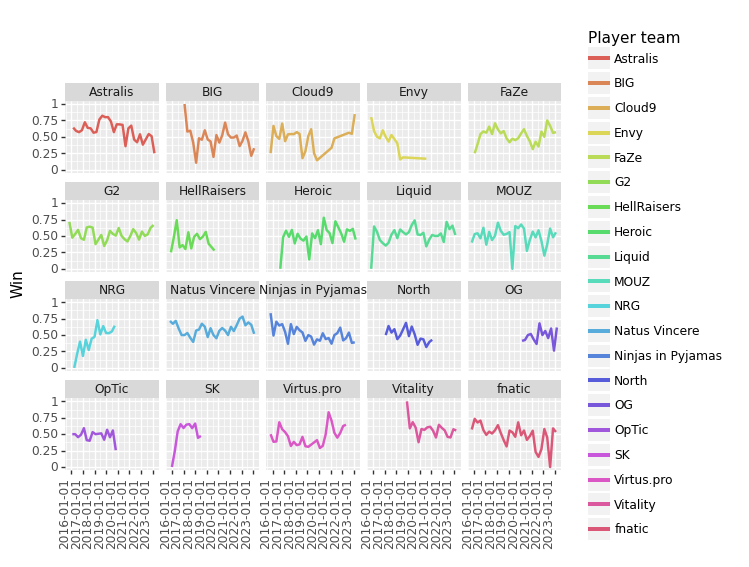

<ggplot: (159666448053)>

In [34]:
ggplot(team_win_overview_top_20,aes(x=team_win_overview_top_20.index,y='Win'))+geom_line(aes(color='Player team'), size=1)+\
facet_wrap('Player team')+\
theme(axis_text_x=element_text(angle=90,hjust=1))

Very interesting that while some of these teams have remained fairly consistent, others have been not able to perform well consistently.


## Machine Learning

### getting all top players data from 2022 to evaluate top 20 players 
from https://www.hltv.org/stats/players?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30

using LAN's data only and top 30 filter only

but still need more info from other pages such as:

In [35]:
def get_top_players_data_dict_from_2022():
    player_sitelink_dict={}
    top_30_link=requests.get('https://www.hltv.org/stats/players?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30')
    content_top_30_soup=bs4.BeautifulSoup(top_30_link.text,'lxml')
    stats_table=content_top_30_soup.findAll('table',class_='stats-table player-ratings-table')[0]
    stats_table_tbody=stats_table.find('tbody')
    stats_table_tbody_top30_info_list=stats_table_tbody.findAll('td',class_='playerCol')
    for i in range(len(stats_table_tbody_top30_info_list)):
        player_sitelink_dict[stats_table_tbody_top30_info_list[i].text]='https://www.hltv.org'+stats_table_tbody_top30_info_list[i].find('a')['href']
    return player_sitelink_dict

def get_top_players_data_from_2022_tandct():
    player_sitelink_dict_ct={}
    top_30_link=requests.get('https://www.hltv.org/stats/players?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30&side=COUNTER_TERRORIST')
    content_top_30_soup=bs4.BeautifulSoup(top_30_link.text,'lxml')
    stats_tables=content_top_30_soup.findAll('tr')
    for table in stats_tables[1:]:
        name=table.findAll('td')[0].text
        rating=float(table.findAll('td')[-1].text)
        player_sitelink_dict_ct[name]=rating
        
    player_sitelink_dict_t={}
    top_30_link=requests.get('https://www.hltv.org/stats/players?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30&side=TERRORIST')
    content_top_30_soup=bs4.BeautifulSoup(top_30_link.text,'lxml')
    stats_tables=content_top_30_soup.findAll('tr')
    for table in stats_tables[1:]:
        name=table.findAll('td')[0].text
        rating=float(table.findAll('td')[-1].text)
        player_sitelink_dict_t[name]=rating
    df_ct=pd.DataFrame.from_dict(player_sitelink_dict_ct,orient='index',columns=['ct_rating'])
    df_t=pd.DataFrame.from_dict(player_sitelink_dict_t,orient='index',columns=['t_rating'])
    df_final=pd.concat([df_ct,df_t],axis=1)
    return df_final



def get_top_players_data_from_2022_clutch():
    player_sitelink_dict=get_top_players_data_dict_from_2022()
    player_clutch_dict={}
    for players_name,players_link in list(player_sitelink_dict.items()):
        clutch_sum=0
        for i in [1,2,3,4,5]:
            tem_link=players_link.replace('players/','players/clutches/')
            tem_link=tem_link.replace(re.search(r'\w+',players_name.lower()).group().lower(),'1on'+str(i)+'/'+re.search(r'\w+',players_name.lower()).group().lower())
            players_page=requests.get(tem_link)
            players_soup=bs4.BeautifulSoup(players_page.text,'lxml')
            players_box=int(players_soup.findAll('div',class_='value')[0].text)
            clutch_sum=clutch_sum+players_box
        player_clutch_dict[players_name]=clutch_sum
    return pd.DataFrame.from_dict(player_clutch_dict,orient='index',columns=['1vX'])
#https://www.hltv.org/stats/players/clutches/11893/1on1/zywoo?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30 
#https://www.hltv.org/stats/players/11893/zywoo?startDate=2022-01-01&endDate=2022-12-31&matchType=Lan&rankingFilter=Top30
    
    
    
    
def get_top_players_data_from_2022():
    player_sitelink_dict=get_top_players_data_dict_from_2022()
    rows=[]
    for players_name,players_link in player_sitelink_dict.items():
        res=[]
        players_page=requests.get(players_link)
        players_soup=bs4.BeautifulSoup(players_page.text,'lxml')
        players_team=players_soup.findAll('div',class_='SummaryTeamname text-ellipsis')[0].text
        players_age=int(players_soup.findAll('div',class_='summaryPlayerAge')[0].text.split()[0])
        players_match_played=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[6].text).group())
        players_round_played=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[7].text).group())
        player_total_killed=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[0].text).group())
        player_total_death=int(re.search(r'\d+',players_soup.findAll('div',class_='stats-row')[2].text).group())
        player_kd_diff=player_total_killed-player_total_death
        players_rating_2_0=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[0].text)
        players_DPR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[1].text)
        players_KAST=players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[2].text
        players_impact=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[3].text)
        players_ADR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[4].text)
        players_KPR=float(players_soup.findAll('div',class_='summaryStatBreakdownDataValue')[5].text)
        
        players_AssistsPR=float(re.search(r'\d\.\d\d',players_soup.findAll('div',class_='stats-row')[9].text).group())
        players_rating_again_top5=float(players_soup.findAll('div',class_='rating-value')[0].text)
        players_HS_rate=re.search(r'\d\d\.\d+',players_soup.findAll('div',class_='stats-row')[1].text).group()
        res.append([players_name,players_team,players_age,players_match_played,players_round_played,player_total_killed,player_total_death,player_kd_diff,players_rating_2_0,players_DPR,players_KAST,players_impact,players_ADR,players_KPR,players_AssistsPR,players_rating_again_top5,players_HS_rate])
        rows=rows+res
    df=pd.DataFrame(rows,columns=['name','team','age','Match Played','Round Played','Total Kill','Total Death','KD Diff','Rating 2.0','DPR','KAST','Impact','ADR','KPR','AssistPR','Rating vs top5','HS Rate'])
      
    return df



In [36]:

if not os.path.exists('top_players_stats_from_2022.pickle'):
    top_players_stats_from_2022=get_top_players_data_from_2022()
    top_players_stats_from_2022.to_pickle('top_players_stats_from_2022.pickle')
else:
    top_players_stats_from_2022 = pd.read_pickle('top_players_stats_from_2022.pickle')
top_players_stats_from_2022

,name,team,age,Match Played,Round Played,Total Kill,Total Death,KD Diff,Rating 2.0,DPR,KAST,Impact,ADR,KPR,AssistPR,Rating vs top5,HS Rate
0,s1mple,Natus Vincere,25,118,3205,2648,1957,691,1.25,0.61,73.8%,1.31,82.9,0.83,0.10,1.22,39.6
1,ZywOo,Vitality,22,131,3596,2842,2133,709,1.25,0.59,75.5%,1.27,80.7,0.79,0.10,1.22,38.1
2,sh1ro,Cloud9,21,95,2553,1944,1349,595,1.24,0.53,76.6%,1.17,77.3,0.76,0.10,1.19,27.9
3,Ax1Le,Cloud9,20,95,2553,1917,1599,318,1.21,0.63,73.5%,1.23,84.8,0.75,0.14,1.29,43.8
4,blameF,Astralis,25,113,3133,2407,1984,423,1.20,0.63,72.0%,1.25,86.2,0.77,0.14,1.11,38.7
5,NiKo,G2,25,118,3220,2419,2115,304,1.19,0.66,71.5%,1.28,85.6,0.75,0.14,1.19,49.0
6,KSCERATO,FURIA,23,96,2549,1878,1496,382,1.19,0.59,73.2%,1.16,80.4,0.74,0.12,1.19,44.4
7,stavn,Heroic,20,115,3061,2291,1967,324,1.17,0.64,73.2%,1.16,83.0,0.75,0.15,1.07,40.7
8,m0NESY,G2,17,118,3220,2365,1909,456,1.15,0.59,72.7%,1.15,72.9,0.73,0.08,1.24,34.6
9,yuurih,FURIA,23,96,2549,1814,1581,233,1.14,0.62,72.7%,1.08,81.8,0.71,0.17,1.03,40.3


In [37]:
if not os.path.exists('top_players_stats_from_2022_withtandct_and_clutch.pickle'):
    top_players_stats_from_2022_withtandct_and_clutch=pd.concat([get_top_players_data_from_2022_clutch(),get_top_players_data_from_2022_tandct(),top_players_stats_from_2022.set_index(['name'])],axis=1)
    top_players_stats_from_2022_withtandct_and_clutch.to_pickle('top_players_stats_from_2022_withtandct_and_clutch.pickle')
else:
    top_players_stats_from_2022_withtandct_and_clutch = pd.read_pickle('top_players_stats_from_2022_withtandct_and_clutch.pickle')
top_players_stats_from_2022_withtandct_and_clutch

,1vX,ct_rating,t_rating,team,age,Match Played,Round Played,Total Kill,Total Death,KD Diff,Rating 2.0,DPR,KAST,Impact,ADR,KPR,AssistPR,Rating vs top5,HS Rate
s1mple,50,1.33,1.17,Natus Vincere,25,118,3205,2648,1957,691,1.25,0.61,73.8%,1.31,82.9,0.83,0.10,1.22,39.6
ZywOo,62,1.31,1.18,Vitality,22,131,3596,2842,2133,709,1.25,0.59,75.5%,1.27,80.7,0.79,0.10,1.22,38.1
sh1ro,40,1.31,1.18,Cloud9,21,95,2553,1944,1349,595,1.24,0.53,76.6%,1.17,77.3,0.76,0.10,1.19,27.9
Ax1Le,24,1.31,1.12,Cloud9,20,95,2553,1917,1599,318,1.21,0.63,73.5%,1.23,84.8,0.75,0.14,1.29,43.8
blameF,44,1.36,1.05,Astralis,25,113,3133,2407,1984,423,1.20,0.63,72.0%,1.25,86.2,0.77,0.14,1.11,38.7
NiKo,34,1.31,1.06,G2,25,118,3220,2419,2115,304,1.19,0.66,71.5%,1.28,85.6,0.75,0.14,1.19,49.0
KSCERATO,39,1.23,1.14,FURIA,23,96,2549,1878,1496,382,1.19,0.59,73.2%,1.16,80.4,0.74,0.12,1.19,44.4
stavn,44,1.25,1.08,Heroic,20,115,3061,2291,1967,324,1.17,0.64,73.2%,1.16,83.0,0.75,0.15,1.07,40.7
m0NESY,45,1.27,1.03,G2,17,118,3220,2365,1909,456,1.15,0.59,72.7%,1.15,72.9,0.73,0.08,1.24,34.6
yuurih,32,1.24,1.05,FURIA,23,96,2549,1814,1581,233,1.14,0.62,72.7%,1.08,81.8,0.71,0.17,1.03,40.3


#### Analyzing

In [38]:
new_data_with_each_player=pd.concat([original_data,pd.DataFrame(original_data['players'].tolist(),columns=['player1', 'player2','player3','player4','player5','player6'])],axis=1)
new_data_with_each_player.drop(columns=['players'])

NameError: name 'original_data' is not defined

In [ ]:
new_data_with_each_player

In [ ]:
original_data['player1']=original_data['players']

In [ ]:
original_data['players']

In [ ]:
def all_mondays(year): 
    return pd.date_range(start=str(year), end=str(year + 1), freq='W-MON').tolist()

def all_ranking_days_uptotoday():
    days = []
    firstRanking = pd.to_datetime(pd.Timestamp(year=2015, month=10, day=26))    
    for i in range(2015, datetime.datetime.today().year+1):
        days += all_mondays(i)   #now need to select days that are in the range
    days_final=[x for x in days if x>=firstRanking and x<=datetime.datetime.today()]
    return days_final


In [ ]:
#,points
site=requests.get('https://www.hltv.org/ranking/teams/2019/january/7')
content=bs4.BeautifulSoup(site.text,'lxml')
content_text=content.findAll('div',{'class' : 'ranked-team standard-box'})[5].text
#re.search(r'#\d+',content_text)
a=content.findAll('div',{'class' : 'ranked-team standard-box'})[29]
b=a.findAll('div',{'class' : 'nick'})
c=a.find('span',{'class' : 'points'}).text
int(re.search(r'\d+',c).group())

In [ ]:
all_ranking_days_uptotoday()

In [ ]:
all_ranking_days()

In [ ]:
def getdaydataindf_mondayornotmonday_version1(date_in_format):   
    '''
    2022/12/06 fixing the issue of a team with only 3 names not a usual 5 names
    remaining issue: 1. want to change Player list into 5 columns but some teams only have 3 members at the moment (resolved in version2)
    
    '''
   
    b=date_in_format-pd.Timedelta(days=date_in_format.dayofweek)
    datelink='https://www.hltv.org/ranking/teams/'+str(b.year)+'/'+str(b.month_name()).lower()+'/'+str(b.day)
    site=requests.get(datelink)
    content=bs4.BeautifulSoup(site.text,'lxml')
    
    teamlist=[]

    for i in range(len(content.select('.name'))):
        teamlist.append(content.select('.name')[i].get_text())
    playerlist=[]
                                    
    for j in range(len(content.select('.playersLine'))):                                 
        playerlist.append(content.select('.playersLine')[j].get_text())
        
    for x in range(len(playerlist)):
        playerlist[x]=playerlist[x].replace('\n',' ')    
    
    csgoteamplayer_dict={}

    for k in range(len(teamlist)):
        csgoteamplayer_dict[teamlist[k]]=playerlist[k]
        
    df=pd.DataFrame.from_dict(csgoteamplayer_dict,orient='index')
    df['Rank']=list(range(1,len(teamlist)+1))    #list rank during that week
    df['Date']=date_in_format                  #list that date
    
    return df

In [ ]:
getdaydataindf_mondayornotmonday_version1(pd.to_datetime('2016/1/5'))

In [ ]:
def getdaydataindf_mondayornotmonday_version2(date_in_format):   
    '''
    resolved1: resolve version1's issue1
    issue1: too slow, need to open 365 sites per year
    issue2 (resolved here): some years have only top 20 teams stats (resolved)
    issue3: during some year, weekly top team stats do not update on Monday (occationaly)  
    '''
    b=date_in_format-pd.Timedelta(days=date_in_format.dayofweek)
    datelink='https://www.hltv.org/ranking/teams/'+str(b.year)+'/'+str(b.month_name()).lower()+'/'+str(b.day)
    site=requests.get(datelink)
    content=bs4.BeautifulSoup(site.text,'lxml')
    
    teamlist=[]

    for i in range(len(content.select('.name'))):
        teamlist.append(content.select('.name')[i].get_text())
    playerlist=[]

    for j in range(len(content.select('.playersLine'))):                                 
        playerlist.append(content.select('.playersLine')[j].get_text())
    
    for k in range(len(content.select('.playersLine'))):                                 
        playerlist[k]=playerlist[k].replace(' ','')

    for x in range(len(playerlist)):
        playerlist[x]=playerlist[x].replace('\n',' ')    
        playerlist[x]=playerlist[x].split()

    for y in range(len(teamlist)):                              #solve version1's issue 1
        while len(playerlist[y])<5:
            playerlist[y].append('Nah')


    csgoteamplayer_dict={}

    for k in range(len(teamlist)):
        csgoteamplayer_dict[teamlist[k]]=playerlist[k]

    df=pd.DataFrame(csgoteamplayer_dict).transpose()
    df['Rank']=list(range(1,len(teamlist)+1))   #list rank during that week
    df['Date']=date_in_format                  #list that date
    
    return df


In [ ]:
getdaydataindf_mondayornotmonday_version2(pd.to_datetime('2020 jan 3'))

In [ ]:
csgoteamplayer_dict  #top 30 team in that week (starting from Monday)

In [ ]:
nextday=a+pd.Timedelta(days=7)
nextdaylink='https://www.hltv.org/ranking/teams/'+str(nextday.year)+'/'+str(nextday.month_name()).lower()+'/'+str(nextday.day)
nextdaylink

In [ ]:
content.select('.ranking-country')[1] #可以找到每个地区最强的俱乐部

In [ ]:
datatext=content.select('.regional-ranking-header')[0].get_text()
datatext.find('on')
datatext.find('\n')
datetext=datatext[23:42]
df['Date']=pd.to_datetime(datetext)


In [ ]:
a=pd.to_datetime(datetext)
a-pd.Timedelta(days=1)


In [ ]:
len(content.select('.nick'))

In [ ]:
csgoteamplayer_dict

In [ ]:
df=pd.DataFrame(csgoteamplayer_dict,index=['Player1','Player2','Player3','Player4','Player5']).transpose()

In [ ]:
df['Rank']=list(range(1,31))

In [ ]:
df

In [ ]:
content.select('.name')[0].get_text()

In [ ]:
content.select('.rankingNicknames')

In [ ]:
len(content.select('.name'))

In [ ]:
content.select('.standard-box')

In [ ]:
a='hello '
a.count('a')

In [ ]:
set(a)

In [ ]:
from collections import Counter

In [ ]:
Counter(a)

In [ ]:
Counter(a)['b']